In [1]:
!ls /usr/lib/jvm
!java -version
!wget http://apache.osuosl.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install yfinance
!pip install pandas-datareader

default-java  java-1.11.0-openjdk-amd64  java-11-openjdk-amd64
openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
--2021-07-29 09:17:53--  http://apache.osuosl.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
Resolving apache.osuosl.org (apache.osuosl.org)... 64.50.233.100, 64.50.236.52, 140.211.166.134, ...
Connecting to apache.osuosl.org (apache.osuosl.org)|64.50.233.100|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228834641 (218M) [application/x-gzip]
Saving to: ‘spark-3.1.2-bin-hadoop3.2.tgz’

spark-3.1.2-bin-had 100%[===================>] 218.23M  37.1MB/s    in 6.8s    

2021-07-29 09:18:00 (32.3 MB/s) - ‘spark-3.1.2-bin-hadoop3.2.tgz’ saved [228834641/228834641]

     |████████████████████████████████| 6.3 MB 11.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha25

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.11.0-openjdk-amd64"
os.environ["PATH"] = os.environ["PATH"] + "$JAVA_HOME/bin:$PATH"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
!source ~/.bashrc
print (os.environ["JAVA_HOME"])

/usr/lib/jvm/java-1.11.0-openjdk-amd64


In [3]:
#Provides findspark.init() to make pyspark importable as a regular library.
import findspark
findspark.init()
import pyspark.sql.functions as F

try:
    sc.stop()
except:
    pass
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = SparkConf().setAppName("StockAnalyzer").setMaster("local[*]")#local[2]
sc=SparkContext(conf = conf)
spark = SparkSession(sparkContext=sc)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/MyDrive/*.csv.gz

!zcat /comments.csv.gz | head -n 100

In [25]:
# Read the raw data csv file into a dataframe.
comments_raw = spark.read.options(header=True,delimiter=",",escape="\"",quote="\"").csv("comments.csv.gz").na.drop()

In [26]:
comments_raw.show(10,truncate=True)

+--------------------+-----------+-------+---------+-----+
|                body|created_utc|     id|  link_id|score|
+--------------------+-----------+-------+---------+-----+
|            #DIPPING| 1607957482|gftdfol|t3_kcvkwx|    1|
|    NIO and SPCE ftw| 1607957482|gftdfo4|t3_kcvkwx|    1|
|                Flat| 1607957482|gftdfo3|t3_kcvkwx|    1|
|Lol what happened...| 1607957481|gftdfnp|t3_kcvkwx|    1|
|    Jan 22 2021 40.5| 1607957481|gftdfmf|t3_kcvkwx|    1|
|SPCE bounce back ...| 1607957480|gftdfk8|t3_kcvkwx|    1|
|        Nice! Thanks| 1607957479|gftdfif|t3_kcvkwx|    1|
|My sex life would...| 1607957479|gftdfh0|t3_kcvkwx|    1|
|Well that was a g...| 1607957478|gftdffp|t3_kcvkwx|    1|
|This was very gay...| 1607957478|gftdfek|t3_kcvkwx|    1|
+--------------------+-----------+-------+---------+-----+
only showing top 10 rows



In [27]:
comments = comments_raw.withColumn('created_utc', F.from_unixtime(comments_raw.created_utc,"yyyy-MM-dd").cast('timestamp'))

comments.show(2)

+----------------+-------------------+-------+---------+-----+
|            body|        created_utc|     id|  link_id|score|
+----------------+-------------------+-------+---------+-----+
|        #DIPPING|2020-12-14 00:00:00|gftdfol|t3_kcvkwx|    1|
|NIO and SPCE ftw|2020-12-14 00:00:00|gftdfo4|t3_kcvkwx|    1|
+----------------+-------------------+-------+---------+-----+
only showing top 2 rows



In [28]:
stocks = ["TSLA","GME","AMC","SNDL"] #feel free to add more stocks.

def extract_ticker(text):
    for stock in stocks:
        if stock in text:
            return stock
    
    return text

extract_ticker_udf = F.udf(extract_ticker,F.StringType())

In [29]:
daily_stock_counts = comments.selectExpr("created_utc","body")\
    .withColumn('word_counts',\
                F.explode(
                    F.split(
                        F.col('body')
                    ,' ')
                )).where(
                    F.col('word_counts').rlike("|".join(["(" + stock + ")" for stock in stocks]))  #https://stackoverflow.com/questions/58186366/filter-pyspark-dataframe-if-contains-a-list-of-strings
                )\
    .withColumn('word_counts',extract_ticker_udf(F.col('word_counts')))\
    .drop('body')\
    .groupBy('created_utc','word_counts')\
    .count()\
    .orderBy(F.desc('created_utc'),F.desc('count'))

daily_stock_counts.show()

+-------------------+-----------+-----+
|        created_utc|word_counts|count|
+-------------------+-----------+-----+
|2021-02-03 00:00:00|        GME| 3170|
|2021-02-03 00:00:00|        AMC| 1364|
|2021-02-03 00:00:00|       SNDL|  131|
|2021-02-03 00:00:00|       TSLA|  103|
|2021-02-02 00:00:00|        GME|43134|
|2021-02-02 00:00:00|        AMC|21572|
|2021-02-02 00:00:00|       TSLA|  765|
|2021-02-02 00:00:00|       SNDL|  518|
|2021-02-01 00:00:00|        GME|48456|
|2021-02-01 00:00:00|        AMC|35718|
|2021-02-01 00:00:00|       TSLA|  769|
|2021-02-01 00:00:00|       SNDL|  707|
|2021-01-31 00:00:00|        GME|44236|
|2021-01-31 00:00:00|        AMC|19279|
|2021-01-31 00:00:00|       TSLA|  542|
|2021-01-31 00:00:00|       SNDL|   95|
|2021-01-30 00:00:00|        GME|44324|
|2021-01-30 00:00:00|        AMC|24105|
|2021-01-30 00:00:00|       TSLA|  728|
|2021-01-30 00:00:00|       SNDL|  111|
+-------------------+-----------+-----+
only showing top 20 rows



In [30]:
from pyspark.sql.window import Window
from pyspark.sql.functions import days

w = (Window()
    .partitionBy(F.col("word_counts"))
    .orderBy(F.col("created_utc").cast('long'))
    .rangeBetween(-7*24*60*60, 0))

df = daily_stock_counts.withColumn('rolling_average', F.avg("count").over(w))

df.show()

+-------------------+-----------+-----+------------------+
|        created_utc|word_counts|count|   rolling_average|
+-------------------+-----------+-----+------------------+
|2020-12-08 00:00:00|       TSLA| 1255|            1255.0|
|2020-12-09 00:00:00|       TSLA| 2191|            1723.0|
|2020-12-10 00:00:00|       TSLA| 2205|1883.6666666666667|
|2020-12-11 00:00:00|       TSLA| 1219|            1717.5|
|2020-12-12 00:00:00|       TSLA|  436|            1461.2|
|2020-12-13 00:00:00|       TSLA|  477|1297.1666666666667|
|2020-12-14 00:00:00|       TSLA| 1152|1276.4285714285713|
|2020-12-15 00:00:00|       TSLA| 1155|           1261.25|
|2020-12-16 00:00:00|       TSLA| 1115|           1243.75|
|2020-12-17 00:00:00|       TSLA| 1299|           1132.25|
|2020-12-18 00:00:00|       TSLA| 3365|           1277.25|
|2020-12-19 00:00:00|       TSLA|  979|           1247.25|
|2020-12-20 00:00:00|       TSLA|  697|          1279.875|
|2020-12-21 00:00:00|       TSLA| 1539|          1412.62

In [43]:
df.select(F.max(F.col('created_utc'))).show()

+-------------------+
|   max(created_utc)|
+-------------------+
|2021-02-03 00:00:00|
+-------------------+



In [16]:
comments_raw.where(F.col("created_utc").isNull()).count()

716

In [ ]:
tesla_df = df.filter(F.col('word_counts') == "TSLA")

In [36]:
df_pd = tesla_df.toPandas()

In [37]:
df_pd

,created_utc,word_counts,count,rolling_average
0,2020-12-08,TSLA,1255,1255.000000
1,2020-12-09,TSLA,2191,1723.000000
2,2020-12-10,TSLA,2205,1883.666667
3,2020-12-11,TSLA,1219,1717.500000
4,2020-12-12,TSLA,436,1461.200000
5,2020-12-13,TSLA,477,1297.166667
6,2020-12-14,TSLA,1152,1276.428571
7,2020-12-15,TSLA,1155,1261.250000
8,2020-12-16,TSLA,1115,1243.750000
9,2020-12-17,TSLA,1299,1132.250000


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override() 

start = datetime.datetime(2020, 12, 1)
end = datetime.datetime(2021, 4, 11)

tesla_stock = web.DataReader("TSLA", start, end)
tesla_stock.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-01,597.590027,597.849976,572.049988,584.760010,584.760010,40103500
2020-12-02,556.440002,571.539978,541.210022,568.820007,568.820007,47775700
2020-12-03,590.020020,598.969971,582.429993,593.380005,593.380005,42552000
2020-12-04,591.010010,599.039978,585.500000,599.039978,599.039978,29401300
2020-12-07,604.919983,648.789978,603.049988,641.760010,641.760010,56309700


In [45]:
close_px = tesla_stock['Adj Close']
mavg = close_px.rolling(window=7).mean()
close_px.iloc[:]

Date
2020-12-01    584.760010
2020-12-02    568.820007
2020-12-03    593.380005
2020-12-04    599.039978
2020-12-07    641.760010
                 ...    
2021-04-05    691.049988
2021-04-06    691.619995
2021-04-07    670.969971
2021-04-08    683.799988
2021-04-09    677.020020
Name: Adj Close, Length: 89, dtype: float64

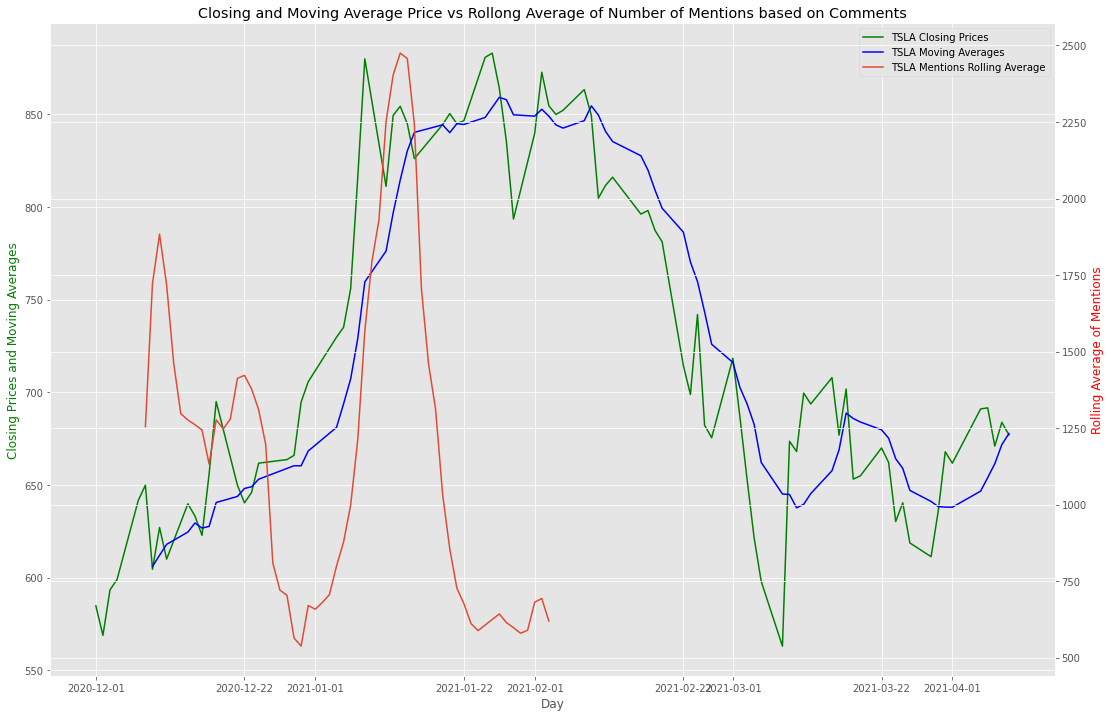

In [50]:
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(18, 12))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
lns1= ax1.plot(close_px, 'g-',label="TSLA Closing Prices")
lns2= ax1.plot(mavg, 'b-',label="TSLA Moving Averages")
lns3= ax2.plot(df_pd['created_utc'],df_pd['rolling_average'],label="TSLA Mentions Rolling Average")
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
# ax1.legend(loc=0)
# ax2.legend(loc="upper left")

ax1.set_xlabel('Day')
ax1.set_ylabel('Closing Prices and Moving Averages', color='g')
ax2.set_ylabel('Rolling Average of Mentions', color='r')
ax1.title.set_text('Closing and Moving Average Price vs Rollong Average of Number of Mentions based on Comments')

plt.show()

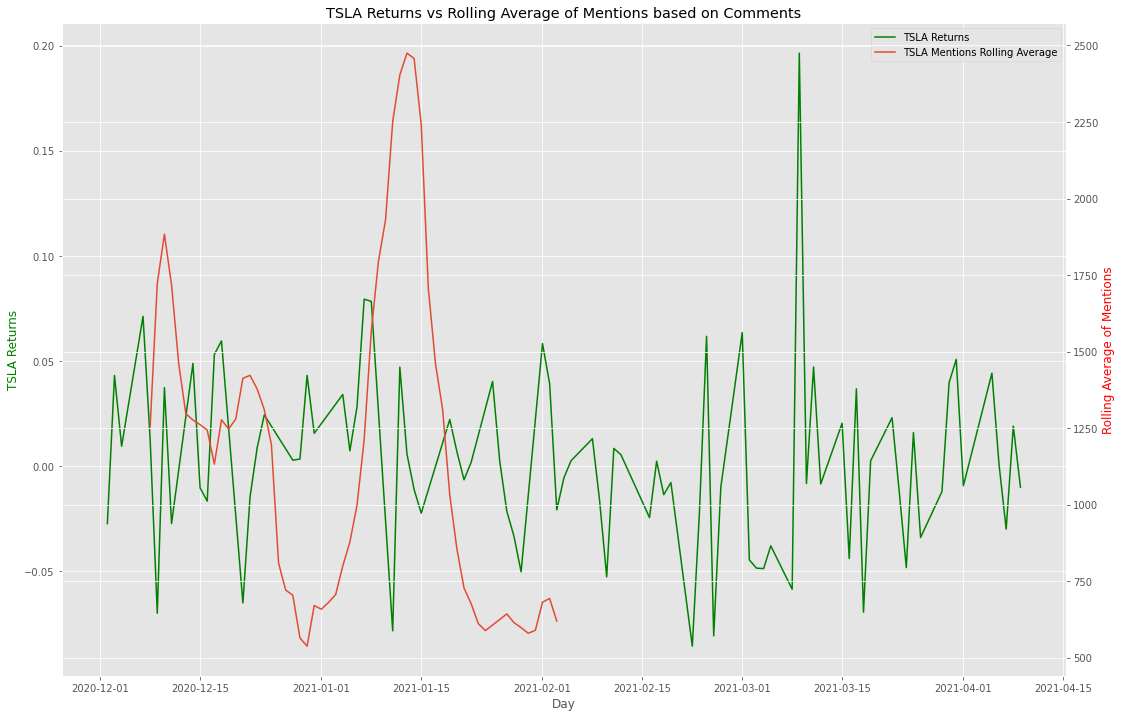

In [49]:
rets = close_px / close_px.shift(1) - 1
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

lns1 = ax1.plot(rets,'g-',label="TSLA Returns")
lns2 = ax2.plot(df_pd['created_utc'],df_pd['rolling_average'],label="TSLA Mentions Rolling Average")
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.set_xlabel('Day')
ax1.set_ylabel('TSLA Returns', color='g')
ax2.set_ylabel('Rolling Average of Mentions', color='r')
ax1.title.set_text('TSLA Returns vs Rolling Average of Mentions based on Comments')

plt.show()